## Imports

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import deque

from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier

## Data load

In [55]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)

## EDA

In [56]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


In [57]:
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


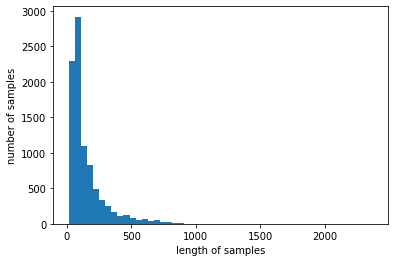

In [58]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

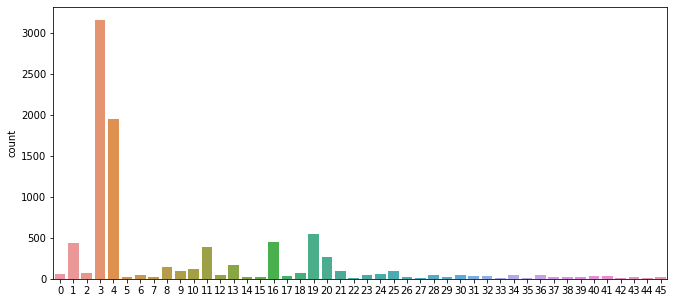

In [59]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

## Decoding

In [60]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

In [61]:
index_to_word = { index+3 : word for word, index in word_index.items() }

In [62]:
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token

In [63]:
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [40]:
print(' '.join([index_to_word[index] for index in [4, 587, 23, 133, 6, 30, 515]]))

the transaction is expected to be completed


In [41]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
print(len(x_train))

8982


In [42]:
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print(len(x_test))

2246


In [43]:
x_train[0]

'<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

## Embedding

In [44]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 9670)


In [45]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 9670)


## Functionalization

#### Functionalize the process of decoding and embedding the training andtest dataset after loading the Reuters news data according to the frequency of words

In [46]:
word_index = reuters.get_word_index(path="reuters_word_index.json")
index_to_word = { index+3 : word for word, index in word_index.items() }
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token
    
dtmvector = CountVectorizer()
tfidf_transformer = TfidfTransformer()

def reuters_embedding(num_words = None ,split = 0.2):
    (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words, test_split = split)
    
    
    ## Decoding
    train_decoded = []
    test_decoded = []

    for i in range(len(x_train)):
        t = ' '.join([index_to_word[index] for index in x_train[i]])
        train_decoded.append(t)
    x_train = train_decoded
    
    
    for i in range(len(x_test)):
        t = ' '.join([index_to_word[index] for index in x_test[i]])
        test_decoded.append(t)
    x_test = test_decoded
    
    
    ## Embedding
    x_train_dtm = dtmvector.fit_transform(x_train)
    tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
    
    x_test_dtm = dtmvector.transform(x_test)
    tfidfv_test = tfidf_transformer.transform(x_test_dtm)

    return tfidfv, y_train, tfidfv_test, y_test

#### Functionalize the process of returning accuracy after learning and training with 8 machine learning models
Use weighted F1-score due to unbalanced distribution of classes

In [47]:
def evaluated_model(y_test, predicted):
    acc = round(accuracy_score(y_test, predicted), 2)
    f1 = round(f1_score(y_test, predicted, average='weighted'), 2)
    
    return acc, f1

In [48]:
def ml_model(tfidfv, y_train, tfidfv_test, y_test):
    
    start = time.time()
    acc = []
    f1 = []
    
    
    # 1. Multinomial Naive Bayes Classifier
    model = MultinomialNB()
    model.fit(tfidfv, y_train)

    predicted = model.predict(tfidfv_test)
    nb_acc, nb_f1 = evaluated_model(y_test, predicted)
    acc.append(nb_acc)
    f1.append(nb_f1)
    print(f"{model.__class__.__name__}의 정확도 : {nb_acc}, \
          F1 score : {nb_f1}")


    # 2. Complement Naive Bayes Classifier
    cb = ComplementNB()
    cb.fit(tfidfv, y_train)

    predicted = cb.predict(tfidfv_test)
    cb_acc, cb_f1 = evaluated_model(y_test, predicted)
    acc.append(cb_acc)
    f1.append(cb_f1)
    print(f"{cb.__class__.__name__}의 정확도 : {cb_acc}, \
          F1 score : {cb_f1}")


    # 3. Logistic Regression
    lr = LogisticRegression(C=10000, penalty='l2')
    lr.fit(tfidfv, y_train)

    predicted = lr.predict(tfidfv_test)
    lr_acc, lr_f1 = evaluated_model(y_test, predicted)
    acc.append(lr_acc)
    f1.append(lr_f1)
    print(f"{lr.__class__.__name__}의 정확도 : {lr_acc}, \
          F1 score : {lr_f1}")


    # 4. Linear Support Vector Machine
    lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
    lsvc.fit(tfidfv, y_train)

    predicted = lsvc.predict(tfidfv_test)
    lsvc_acc, lsvc_f1 = evaluated_model(y_test, predicted)
    acc.append(lsvc_acc)
    f1.append(lsvc_f1)
    print(f"{lsvc.__class__.__name__}의 정확도 : {lsvc_acc}, \
          F1 score : {lsvc_f1}")


    # 5. Decision Tree
    tree = DecisionTreeClassifier(max_depth=10, random_state=0)
    tree.fit(tfidfv, y_train)

    predicted = tree.predict(tfidfv_test)
    tree_acc, tree_f1 = evaluated_model(y_test, predicted)
    acc.append(tree_acc)
    f1.append(tree_f1)
    print(f"{tree.__class__.__name__}의 정확도 : {tree_acc}, \
          F1 score : {tree_f1}")


    # 6. Random Forest
    forest = RandomForestClassifier(n_estimators=5, random_state=0)
    forest.fit(tfidfv, y_train)

    predicted = forest.predict(tfidfv_test)
    forest_acc, forest_f1 = evaluated_model(y_test, predicted)
    acc.append(forest_acc)
    f1.append(forest_f1)
    print(f"{forest.__class__.__name__}의 정확도 : {forest_acc}, \
          F1 score : {forest_f1}")


    # 7. GradientBoostingClassifier
    grbt = GradientBoostingClassifier(random_state=0) # verbose=3
    grbt.fit(tfidfv, y_train)

    predicted = grbt.predict(tfidfv_test)
    grbt_acc, grbt_f1 = evaluated_model(y_test, predicted)
    acc.append(grbt_acc)
    f1.append(grbt_f1)
    print(f"{grbt.__class__.__name__}의 정확도 : {grbt_acc}, \
          F1 score : {grbt_f1}")


    # 8. Voting
    voting_classifier = VotingClassifier(estimators=[
             ('lr', LogisticRegression(C=10000, penalty='l2')),
            ('cb', ComplementNB()),
            ('grbt', GradientBoostingClassifier(random_state=0))
    ], voting='soft', n_jobs=-1)
    voting_classifier.fit(tfidfv, y_train)

    predicted = voting_classifier.predict(tfidfv_test)
    voting_classifier_acc, voting_classifier_f1 = evaluated_model(y_test, predicted)
    acc.append(voting_classifier_acc)
    f1.append(voting_classifier_f1)
    print(f"{voting_classifier.__class__.__name__}의 정확도 : {voting_classifier_acc}, \
          F1 score : {voting_classifier_f1}")

    print(time.time()-start)
    
    return acc, f1

## Use all words

In [73]:
whole_tfidfv, whole_y_train, whole_tfidfv_test, whole_y_test = reuters_embedding(num_words = None, split = 0.2)

In [74]:
whole_acc, whole_f1 = ml_model(whole_tfidfv, whole_y_train, whole_tfidfv_test, whole_y_test)

MultinomialNB의 정확도 : 0.6,           F1 score : 0.5
ComplementNB의 정확도 : 0.76,           F1 score : 0.73


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression의 정확도 : 0.81,           F1 score : 0.81


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC의 정확도 : 0.79,           F1 score : 0.78
DecisionTreeClassifier의 정확도 : 0.62,           F1 score : 0.58
RandomForestClassifier의 정확도 : 0.65,           F1 score : 0.62
GradientBoostingClassifier의 정확도 : 0.77,           F1 score : 0.76


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier의 정확도 : 0.82,           F1 score : 0.81
2509.267175912857


## Only use the top 5,000 words in frequency

In [75]:
ft_tfidfv, ft_y_train, ft_tfidfv_test, ft_y_test = reuters_embedding(num_words = 5000, split = 0.2)

In [76]:
ft_acc, ft_f1 = ml_model(ft_tfidfv, ft_y_train, ft_tfidfv_test, ft_y_test)

MultinomialNB의 정확도 : 0.67,           F1 score : 0.6
ComplementNB의 정확도 : 0.77,           F1 score : 0.75


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression의 정확도 : 0.81,           F1 score : 0.8


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC의 정확도 : 0.77,           F1 score : 0.77
DecisionTreeClassifier의 정확도 : 0.62,           F1 score : 0.57
RandomForestClassifier의 정확도 : 0.7,           F1 score : 0.68
GradientBoostingClassifier의 정확도 : 0.77,           F1 score : 0.77


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier의 정확도 : 0.82,           F1 score : 0.81
2114.756245136261


## Only use the top 8,000 words in frequency

In [77]:
et_tfidfv, et_y_train, et_tfidfv_test, et_y_test = reuters_embedding(num_words = 8000, split = 0.2)

In [78]:
et_acc, et_f1 = ml_model(et_tfidfv, et_y_train, et_tfidfv_test, et_y_test)

MultinomialNB의 정확도 : 0.66,           F1 score : 0.58
ComplementNB의 정확도 : 0.77,           F1 score : 0.75


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression의 정확도 : 0.81,           F1 score : 0.8


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC의 정확도 : 0.78,           F1 score : 0.77
DecisionTreeClassifier의 정확도 : 0.62,           F1 score : 0.57
RandomForestClassifier의 정확도 : 0.67,           F1 score : 0.64
GradientBoostingClassifier의 정확도 : 0.76,           F1 score : 0.76


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier의 정확도 : 0.81,           F1 score : 0.81
2241.040005683899


## Only use the top 12,000 words in frequency

In [79]:
## Only use the top 5,000 words in frequencytt_tfidfv, tt_y_train, tt_tfidfv_test, tt_y_test = reuters_embedding(num_words = 15000, split = 0.2)

In [80]:
tt_acc, tt_f1 = ml_model(tt_tfidfv, tt_y_train, tt_tfidfv_test, tt_y_test)

MultinomialNB의 정확도 : 0.63,           F1 score : 0.55
ComplementNB의 정확도 : 0.77,           F1 score : 0.74


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression의 정확도 : 0.81,           F1 score : 0.81


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC의 정확도 : 0.78,           F1 score : 0.78
DecisionTreeClassifier의 정확도 : 0.62,           F1 score : 0.58
RandomForestClassifier의 정확도 : 0.67,           F1 score : 0.64
GradientBoostingClassifier의 정확도 : 0.77,           F1 score : 0.77


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier의 정확도 : 0.82,           F1 score : 0.81
2339.180963754654


## Only use the top 16,000 words in frequency

In [81]:
st_tfidfv, st_y_train, st_tfidfv_test, st_y_test = reuters_embedding(num_words = 16000, split = 0.2)

In [82]:
st_acc, st_f1 = ml_model(st_tfidfv, st_y_train, st_tfidfv_test, st_y_test)

MultinomialNB의 정확도 : 0.63,           F1 score : 0.55
ComplementNB의 정확도 : 0.77,           F1 score : 0.74


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression의 정확도 : 0.81,           F1 score : 0.81


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC의 정확도 : 0.78,           F1 score : 0.77
DecisionTreeClassifier의 정확도 : 0.62,           F1 score : 0.58
RandomForestClassifier의 정확도 : 0.67,           F1 score : 0.64
GradientBoostingClassifier의 정확도 : 0.77,           F1 score : 0.77


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier의 정확도 : 0.82,           F1 score : 0.81
2339.4776153564453


## Performance of 8 machine learning models by vocabulary size

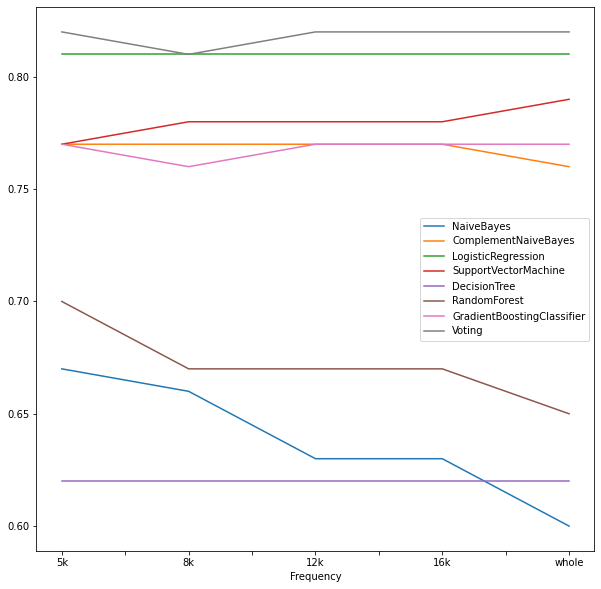

In [21]:
whole_acc = deque(whole_acc)
whole_acc.appendleft('whole')

ft_acc = deque(ft_acc)
ft_acc.appendleft('5k')

et_acc = deque(et_acc)
et_acc.appendleft('8k')

tt_acc = deque(tt_acc)
tt_acc.appendleft('12k')

st_acc = deque(st_acc)
st_acc.appendleft('16k')


data = [ft_acc,
        et_acc,
        tt_acc,
        st_acc,
        whole_acc]
 
# form dataframe from data
df = pd.DataFrame(data, columns=["Frequency", "NaiveBayes", "ComplementNaiveBayes", "LogisticRegression", "SupportVectorMachine", "DecisionTree", "RandomForest", "GradientBoostingClassifier", "Voting"])
 
# plot multiple columns such as population and year from dataframe
df.plot(x="Frequency", y=["NaiveBayes", "ComplementNaiveBayes", "LogisticRegression", "SupportVectorMachine", "DecisionTree", "RandomForest", "GradientBoostingClassifier", "Voting"],
        kind="line", figsize=(10, 10))
 
# display plot
plt.show()

In [22]:
df

,Frequency,NaiveBayes,ComplementNaiveBayes,LogisticRegression,SupportVectorMachine,DecisionTree,RandomForest,GradientBoostingClassifier,Voting
0,5k,0.67,0.77,0.81,0.77,0.62,0.70,0.77,0.82
1,8k,0.66,0.77,0.81,0.78,0.62,0.67,0.76,0.81
2,12k,0.63,0.77,0.81,0.78,0.62,0.67,0.77,0.82
3,16k,0.63,0.77,0.81,0.78,0.62,0.67,0.77,0.82
4,whole,0.60,0.76,0.81,0.79,0.62,0.65,0.77,0.82


In [26]:
df.iloc[:,1:].mean(axis='columns')

0    0.74125
1    0.73500
2    0.73375
3    0.73375
4    0.72750
dtype: float64

## Deep learning model

#### Load and preprocessing

In [71]:
(X_train, Y_train), (X_test, Y_test) = reuters.load_data(num_words=5000, test_split=0.2)

vocab_size = 5000
max_len = 500

x_train = pad_sequences(X_train, maxlen=max_len)
x_test = pad_sequences(X_test, maxlen=max_len)

y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)

s_len = [len(s) for s in X_train]
print("# of sentences less than 500 in length :", sum([int(i<=500) for i in s_len]))
print("Ratio of sentences less than 500 in length :", sum([int(i<=500) for i in s_len])/len(X_train))

# of sentences less than 500 in length : 8623
Ratio of sentences less than 500 in length : 0.9600311734580271


#### Modeling

In [72]:
embedding_dim = 128
num_classes = 46

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),                        
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(64, 5, padding='valid', activation='relu', strides=1),
    tf.keras.layers.MaxPooling1D(pool_size=3),
    tf.keras.layers.LSTM(units=num_classes),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          640000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 496, 64)           41024     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 165, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 46)                20424     
_________________________________________________________________
dense_1 (Dense)              (None, 46)                2162      
Total params: 703,610
Trainable params: 703,610
Non-trainable params: 0
________________________________________________

#### Test

Epoch 1/15
281/281 [==============================] - 100s 347ms/step - loss: 2.1315 - accuracy: 0.4755 - val_loss: 1.7810 - val_accuracy: 0.5788
Epoch 2/15
281/281 [==============================] - 95s 340ms/step - loss: 1.6003 - accuracy: 0.6065 - val_loss: 1.8162 - val_accuracy: 0.5236
Epoch 3/15
281/281 [==============================] - 96s 342ms/step - loss: 1.5330 - accuracy: 0.6209 - val_loss: 1.5600 - val_accuracy: 0.6233
Epoch 4/15
281/281 [==============================] - 96s 341ms/step - loss: 1.3345 - accuracy: 0.6799 - val_loss: 1.4442 - val_accuracy: 0.6581
Epoch 5/15
281/281 [==============================] - 95s 339ms/step - loss: 1.2102 - accuracy: 0.7032 - val_loss: 1.3404 - val_accuracy: 0.6741
Epoch 6/15
281/281 [==============================] - 95s 339ms/step - loss: 1.0960 - accuracy: 0.7275 - val_loss: 1.3043 - val_accuracy: 0.6825
Epoch 7/15
281/281 [==============================] - 94s 333ms/step - loss: 0.9835 - accuracy: 0.7565 - val_loss: 1.2678 - val_a

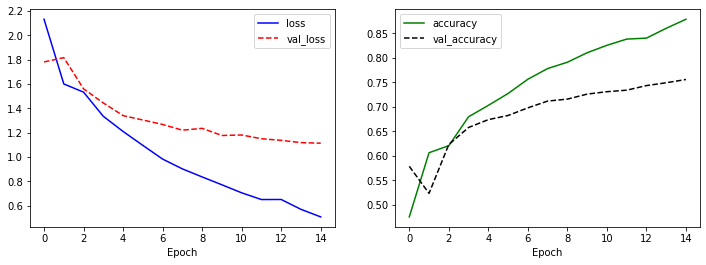

In [73]:
# 모델의 실행
history = model.fit(x_train, y_train, epochs=15, batch_size=32, callbacks=[es, mc], validation_data=(x_test, y_test))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Discussion

1. 분류 모델의 accuracy가 기준 이상 높게 나왔는가?  
 - 3가지 단어 개수에 대해 8가지 머신러닝 기법을 적용하여 그중 최적의 솔루션을 도출하였다.  
 
 
2. 분류 모델의 F1 score가 기준 이상 높게 나왔는가?  
 - Vocabulary size에 따른 각 머신러닝 모델의 성능변화 추이를 살피고, 해당 머신러닝 알고리즘의 특성에 근거해 원인을 분석하였다.  
 
 
3. 딥러닝 모델을 활용해 성능이 비교 및 확인되었는가?  
 - 동일한 데이터셋과 전처리 조건으로 딥러닝 모델의 성능과 비교하여 결과에 따른 원인을 분석하였다.  

## Reference

1. https://github.com/miinkang/AI_Project_AIFFEL/blob/main/%5BGD-04%5DTFIDF_vectorization.ipynb
2. https://pybasall.tistory.com/275
3. https://blog.naver.com/wideeyed/221622877426
4. https://www.geeksforgeeks.org/how-to-plot-multiple-data-columns-in-a-dataframe/
5. https://dev-dain.tistory.com/92
6. https://wikidocs.net/22933
7. https://leonkong.cc/posts/python-deque.html